In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.pullsNum = np.zeros(narms)
        self.values = np.full(narms, Q0)
        
    def play(self, tround, context=None):
        # tround not used in this implementation of MAB
        rand = np.random.random()
        # if rand < epsilon, pick random arm (explore), otherwise pick best arm (exploit) (with random tiebreak)
        if rand < self.epsilon:
            return np.random.randint(self.narms)
        else:
            maxValue = max(self.values)
            bestArms = [i for i, value in enumerate(self.values) if value == maxValue]
            return np.random.choice(bestArms)
        
    def update(self, arm, reward, context=None):
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            value = (self.values[arm] * self.pullsNum[arm] + reward) / (self.pullsNum[arm] + 1)
            self.values[arm] = value
        self.pullsNum[arm] += 1
    

In [5]:
class BernoulliArm:
    def __init__(self):
        self.p = np.random.random()
    
    def pull(self):
        return int(np.random.random() < self.p)

In [6]:
bernoulliArms = [BernoulliArm() for i in range(10)]
[a.p for a in bernoulliArms]

[0.5958247637816033,
 0.49821203694769145,
 0.4698340777536778,
 0.13654880847204842,
 0.30010162192872747,
 0.135649267845232,
 0.07962893111805402,
 0.5425442355292646,
 0.835203872881285,
 0.6361306124057975]

In [7]:
epsGreedy = EpsGreedy(10, 0.2)
accumulated_rewards = 0
pulls_num = 0
running_avg_rewards = [0] * 300
# print(epsGreedy.values)
for i in range(0, 300):
    arm = epsGreedy.play(None)
    reward = bernoulliArms[arm].pull()
    accumulated_rewards += reward
    epsGreedy.update(arm, reward)
    
    pulls_num += 1
    running_avg_rewards[i] = accumulated_rewards / pulls_num
    
#     if (i % 100 == 0):
#         print("-")
#         print(accumulated_rewards)
#         print(epsGreedy.values)
#         print("-")

print("accumulated_rewards " + str(accumulated_rewards))
# print(epsGreedy.values)
print("max reward possible " + str(max([b.p for b in bernoulliArms])*300))
print("regret " + str(max([b.p for b in bernoulliArms]) * 300 - accumulated_rewards))

accumulated_rewards 222
max reward possible 250.5611618643855
regret 28.561161864385497


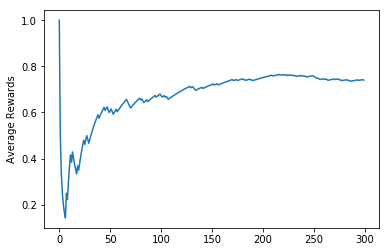

In [8]:
plt.plot(running_avg_rewards)
plt.ylabel("Average Rewards")
plt.show()

In [23]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.pullsNum = np.zeros(narms)
        self.values = np.full(narms, Q0)
    
    def play(self, tround, context=None):
        # compute the sum of average reward and confidence interval for each arm
        estimatedValues = [0] * self.narms
        for i in range(self.narms):
            avg_arm_value = self.values[i]
            if avg_arm_value == self.Q0:
                estimatedValues[i] = self.Q0
            else:
                confidence_interval = np.sqrt((self.rho * np.log(tround)) / self.pullsNum[i])
                estimatedValues[i] = avg_arm_value + confidence_interval
        
        # choose randomly between arms with max sum of avg reward and confidence interval
        maxValue = max(estimatedValues)
        bestArms = [i for i, value in enumerate(estimatedValues) if value == maxValue]
        return np.random.choice(bestArms)
        
    def update(self, arm, reward, context=None):
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            value = (self.values[arm] * self.pullsNum[arm] + reward) / (self.pullsNum[arm] + 1)
            self.values[arm] = value
        self.pullsNum[arm] += 1
        
    

In [37]:
bernoulliArms = [BernoulliArm() for i in range(10)]
[a.p for a in bernoulliArms]

[0.30285063868800766,
 0.5489417720476272,
 0.4945385525966577,
 0.4891175281368223,
 0.9121946616676647,
 0.2111246016416537,
 0.9436084678448871,
 0.578253605163825,
 0.6109595109577761,
 0.4254153688254443]

In [48]:
mab = UCB(10, 0.0)
accumulated_rewards = 0
# print(epsGreedy.values)
for i in range(0, 2000):
    arm = mab.play(i)
    reward = bernoulliArms[arm].pull()
    accumulated_rewards += reward
    mab.update(arm, reward)

#     if (i % 100 == 0):
#         print("-")
#         print(accumulated_rewards)
#         print(epsGreedy.values)
#         print("-")

print("accumulated_rewards " + str(accumulated_rewards))
print(mab.values)
maxReward = max([b.p for b in bernoulliArms])*2000
print("max reward possible " + str(maxReward))
print("regret " + str(maxReward - accumulated_rewards))

#[a.p for a in bernoulliArms]

accumulated_rewards 1879
[0.         0.5        0.66666667 0.66666667 0.925      0.
 0.94341564 0.66666667 0.5        0.        ]
max reward possible 1887.2169356897741
regret 8.216935689774118


## 2. Off-Policy Evaluation

In [12]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    

In [13]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

NameError: name 'arms' is not defined

In [ ]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

In [ ]:
data = np.loadtxt("dataset.txt")
arm_id = data[:,0]
reward = data[:,1]
context = data[:,2:]

## 3. Contextual Bandits

In [ ]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
        
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    

In [ ]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

## 4. Evaluation
### 4.A.

### 4.B.

## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    